In [174]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.path.append("/export/raid1/home/styvesg/code/")
sys.path.append("/export/raid1/home/styvesg/code/nsd_gnet8x/")
sys.path.append("/export/raid1/home/styvesg/code/nsd_manifold/")

import nsd_gnet8x.src.numpy_utility as pnu
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from nsd_gnet8x.src.config import *

%matplotlib inline

In [3]:
import torch
use_device = "cuda:0"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [4]:
def round10up(x):
    return 10**np.ceil(np.log10(x))
def round10down(x):
    return 10**np.floor(np.log10(x))

In [5]:
input_dir = "../nsd_gnet8x/output/multisubject/gnet8j64t192_mpf_general_Jan-25-2023_1316/"
output_dir = input_dir

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

# Reload joined GNet model files

In [29]:
joined_checkpoint = torch.load(input_dir + 'model_params_final', map_location=use_device)
print (joined_checkpoint.keys())

dict_keys(['num_epochs', 'batch_size', 'holdout_frac', 'best_params', 'final_params', 'trn_loss_history', 'hold_loss_history', 'hold_cc_history', 'best_epoch', 'best_joint_cc_score', 'val_cc', 'input_mean', 'brain_nii_shape', 'voxel_index', 'voxel_roi', 'voxel_mask'])


In [30]:
subjects = list(joined_checkpoint['voxel_mask'].keys())
gnet8j_voxel_mask = joined_checkpoint['voxel_mask']
gnet8j_voxel_roi  = joined_checkpoint['voxel_roi']
gnet8j_voxel_index= joined_checkpoint['voxel_index']
gnet8j_brain_nii_shape= joined_checkpoint['brain_nii_shape']
gnet8j_val_cc = joined_checkpoint['val_cc']

In [31]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)
def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, torch.from_numpy(xb).to(device))

In [32]:
# due to allocation issue at one time, the specific model instanciation is baked into these methods.
from nsd_gnet8x.src.torch_gnet_dev import Encoder
from nsd_gnet8x.src.tuning_dev import gnet8j_predictions

In [34]:
#gnet8j_image_pred = gnet8j_predictions(stim_data, _pred_fn, 64, 192, joined_checkpoint, batch_size=100, device=device)

In [35]:
#plt.figure(figsize=(30,12))
#plt.imshow(gnet8j_image_pred[1].T, cmap='seismic', vmin=-2, vmax=2)
#plt.colorbar()

# Load a few example image from the imagenet training set

In [27]:
imagenet_root = root_dir + "../../data/imagenet/"

In [28]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
            transforms.Resize(227), # smallest dimension will be resized to that size
            transforms.CenterCrop((227, 227)), # crop the edges of non-square images
            transforms.ToTensor(), # this automatically convert from uint8 to float in range [0,1]
        ])

inet_val = datasets.ImageNet(imagenet_root, 'val', transform=data_transform)
inet_trn = datasets.ImageNet(imagenet_root, 'train', transform=data_transform)

In [29]:
label_map = inet_trn.classes
wnids_map = inet_trn.wnids

In [30]:
print (len(label_map))
print (len(wnids_map))
print (len(inet_trn))

1000
1000
1280449


In [31]:
import torch
val_dataloader = torch.utils.data.DataLoader(inet_val, batch_size=10000, shuffle=True, num_workers=4)
trn_dataloader = torch.utils.data.DataLoader(inet_trn, batch_size=10000, shuffle=True, num_workers=4)

In [32]:
imagenet_trn_10k_images, imagenet_trn_10k_labels = next(iter(trn_dataloader))
print (imagenet_trn_10k_images.shape, imagenet_trn_10k_labels.shape)

torch.Size([10000, 3, 227, 227]) torch.Size([10000])


In [33]:
inputs, labels = next(iter(trn_dataloader))
print (inputs.shape, labels.shape)

torch.Size([10000, 3, 227, 227]) torch.Size([10000])


[('grand piano', 'grand'), ('patio', 'terrace'), ('bullet train', 'bullet'), ('hippopotamus', 'hippo', 'river horse', 'Hippopotamus amphibius'), ('koala', 'koala bear', 'kangaroo bear', 'native bear', 'Phascolarctos cinereus'), ('black grouse',), ('head cabbage',), ('bustard',), ('partridge',), ('pickelhaube',), ('Irish setter', 'red setter'), ('combination lock',), ('Norwich terrier',), ('king snake', 'kingsnake'), ('agama',), ('packet',), ('shoe shop', 'shoe-shop', 'shoe store'), ('kuvasz',), ('malamute', 'malemute', 'Alaskan malamute'), ('cockroach', 'roach'), ('remote control', 'remote'), ('bee eater',), ('platypus', 'duckbill', 'duckbilled platypus', 'duck-billed platypus', 'Ornithorhynchus anatinus'), ('ocarina', 'sweet potato')]


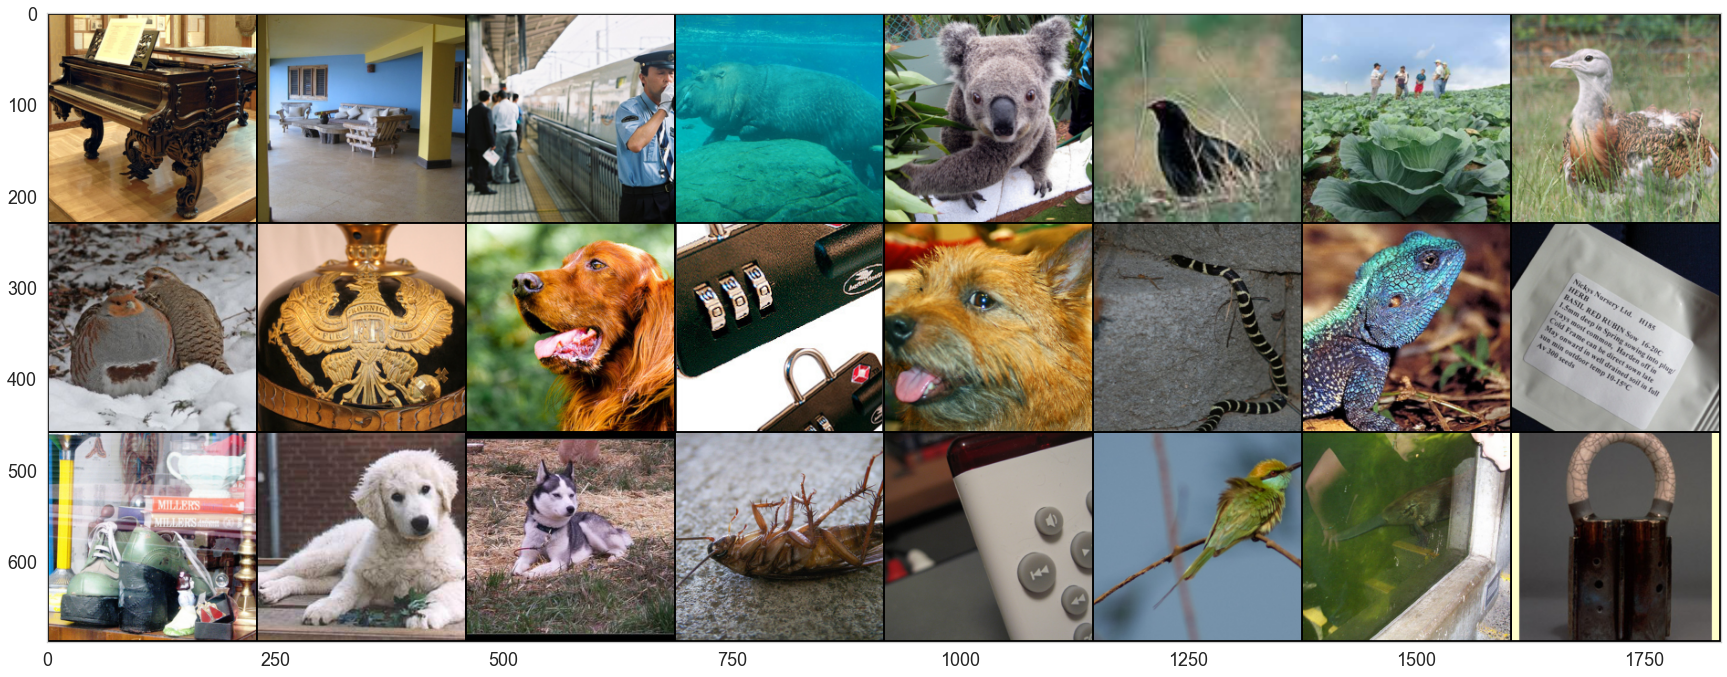

In [34]:
import torchvision
out = torchvision.utils.make_grid(inputs[:24])

fig=plt.figure(figsize=(30,30))
plt.imshow(out.numpy().transpose((1,2,0)), cmap='gray')
plt.grid(False)           
print ([label_map[x] for x in labels[:24]])

In [35]:
im = out.numpy().transpose((1,2,0))
print (im.shape, im.dtype, np.min(im), np.max(im))

(689, 1834, 3) float32 0.0 1.0


# ImageNet Validation image prediction

In [51]:
subject_imnet_pred = {}
for s in subjects:
    subject_imnet_pred[s] = []
pred_id = []

for images, labels in tqdm(val_dataloader):
    pred_id += [labels.numpy(),]
    
    for s in subjects:
        print ('subject %d' %s)
        subject_imnet_pred[s] += [ gnet8j_predictions({s: images.numpy()}, _pred_fn, 64, 192, joined_checkpoint, batch_size=100, device=device)[s],]
        #subject_imnet_pred[s] += [ subjectwise_multi_predictions(images.numpy(), _pred_fn, checkpoint, s, batch_size), ]

# concatenate the batch
pred_id = np.concatenate(pred_id, axis=0)
for s in subjects:
    subject_imnet_pred[s] = np.concatenate(subject_imnet_pred[s], axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8


 20%|██        | 1/5 [02:08<08:32, 128.15s/it]

subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8


 40%|████      | 2/5 [03:04<04:17, 85.88s/it] 

subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8


 60%|██████    | 3/5 [03:58<02:22, 71.45s/it]

subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8


 80%|████████  | 4/5 [04:53<01:04, 64.72s/it]

subject 1
subject 2
subject 3
subject 4
subject 5
subject 6
subject 7
subject 8


100%|██████████| 5/5 [05:49<00:00, 69.86s/it]


In [53]:
# test values
print (subject_imnet_pred[1].shape)
print (len(inet_val))

(50000, 11838)
50000


In [54]:
from src.file_utility import save_stuff, flatten_dict, embed_dict

save_stuff( output_dir + 'imagenet_val_pred_all', 
    flatten_dict({'pred': subject_imnet_pred,
            'label': pred_id,
            'voxel_mask':voxel_mask,
            'voxel_roi': voxel_roi,
            'voxel_index': voxel_index,
            'brain_nii_shape': brain_nii_shape
            }))

saved pred.1 in h5py file
saved pred.2 in h5py file
saved pred.3 in h5py file
saved pred.4 in h5py file
saved pred.5 in h5py file
saved pred.6 in h5py file
saved pred.7 in h5py file
saved pred.8 in h5py file
saved label in h5py file
saved voxel_mask.1 in h5py file
saved voxel_mask.2 in h5py file
saved voxel_mask.3 in h5py file
saved voxel_mask.4 in h5py file
saved voxel_mask.5 in h5py file
saved voxel_mask.6 in h5py file
saved voxel_mask.7 in h5py file
saved voxel_mask.8 in h5py file
saved voxel_roi.1 in h5py file
saved voxel_roi.2 in h5py file
saved voxel_roi.3 in h5py file
saved voxel_roi.4 in h5py file
saved voxel_roi.5 in h5py file
saved voxel_roi.6 in h5py file
saved voxel_roi.7 in h5py file
saved voxel_roi.8 in h5py file
saved voxel_index.1 in h5py file
saved voxel_index.2 in h5py file
saved voxel_index.3 in h5py file
saved voxel_index.4 in h5py file
saved voxel_index.5 in h5py file
saved voxel_index.6 in h5py file
saved voxel_index.7 in h5py file
saved voxel_index.8 in h5py file

# ImageNet Training image prediction
### Training block which we'll have to reorganize later

In [124]:
temp_dir = output_dir + 'imagenet_pred_block/'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
    
trn_subjects = [1,2,3,4,5,6,7,8]

In [128]:
for k,(images, labels) in tqdm(enumerate(trn_dataloader)):
    pred_id = labels.numpy()
    subject_imnet_pred = gnet8j_predictions({s: images.numpy() for s in trn_subjects}, _pred_fn, 64, 192, joined_checkpoint, batch_size=100, device=device)

    for s in trn_subjects:
        save_stuff( temp_dir + 'imagenet_trn_pred_subj%02d_block%2d'%(s,k), 
            flatten_dict({'pred': subject_imnet_pred[s],
                'label': pred_id,
                'voxel_mask':voxel_mask[s],
                'voxel_roi': voxel_roi[s],
                'voxel_index': voxel_index[s],
                'brain_nii_shape': brain_nii_shape[s]
                }))
        
    del subject_imnet_pred

0it [00:00, ?it/s]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

1it [06:38, 398.65s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

2it [07:56, 209.82s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

3it [09:17, 151.23s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

4it [10:37, 122.88s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

5it [12:25, 117.79s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

6it [13:52, 107.27s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

7it [15:14, 98.90s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

8it [16:39, 94.57s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

9it [18:24, 97.66s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

10it [19:44, 92.17s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

11it [21:07, 89.51s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

12it [22:27, 86.44s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

13it [24:24, 95.79s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

14it [25:45, 91.31s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

15it [27:09, 89.10s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

16it [28:35, 88.23s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

17it [30:35, 97.85s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

18it [31:56, 92.63s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

19it [33:19, 89.82s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

20it [34:43, 88.23s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

21it [36:57, 101.83s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

22it [38:19, 95.79s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

23it [39:43, 92.46s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

24it [41:06, 89.57s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

25it [43:28, 105.12s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

26it [44:49, 97.94s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

27it [46:12, 93.37s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

28it [47:33, 89.70s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

29it [50:07, 109.22s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

30it [51:28, 100.72s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

31it [52:52, 95.49s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

32it [54:12, 91.10s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

33it [56:50, 111.09s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

34it [58:14, 102.86s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

35it [59:37, 96.91s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

36it [1:00:58, 92.07s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

37it [1:03:51, 116.40s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

38it [1:05:14, 106.45s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

39it [1:06:37, 99.50s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

40it [1:07:59, 94.00s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

41it [1:10:58, 119.51s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

42it [1:12:19, 108.23s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

43it [1:13:43, 100.74s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

44it [1:15:04, 94.80s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

45it [1:18:01, 119.51s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

46it [1:19:22, 108.01s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

47it [1:20:47, 101.08s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

48it [1:22:09, 95.34s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

49it [1:25:03, 118.97s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

50it [1:26:23, 107.32s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

51it [1:27:45, 99.69s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

52it [1:29:06, 94.19s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

53it [1:32:06, 119.75s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

54it [1:33:25, 107.73s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

55it [1:34:49, 100.54s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

56it [1:36:09, 94.46s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

57it [1:39:08, 119.69s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

58it [1:40:28, 107.77s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

59it [1:41:51, 100.45s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

60it [1:43:11, 94.20s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

61it [1:46:10, 119.61s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

62it [1:47:30, 107.64s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

63it [1:48:53, 100.36s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

64it [1:50:13, 94.18s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

65it [1:53:19, 121.83s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

66it [1:54:39, 109.41s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

67it [1:56:01, 101.13s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

68it [1:57:23, 95.19s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

69it [2:00:23, 120.89s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

70it [2:01:43, 108.54s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

71it [2:03:05, 100.62s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

72it [2:04:27, 94.96s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

73it [2:07:26, 120.22s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

74it [2:08:46, 108.00s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

75it [2:10:07, 100.11s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

76it [2:11:27, 94.09s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

77it [2:14:33, 121.54s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

78it [2:15:54, 109.27s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

79it [2:17:16, 101.20s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

80it [2:18:37, 95.03s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

81it [2:21:33, 119.38s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

82it [2:22:55, 108.17s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

83it [2:24:19, 100.87s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

84it [2:25:40, 94.90s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

85it [2:28:32, 118.02s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

86it [2:29:52, 106.57s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

87it [2:31:14, 99.36s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

88it [2:32:34, 93.66s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

89it [2:35:35, 119.62s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

90it [2:36:56, 108.03s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

91it [2:38:18, 100.45s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

92it [2:39:40, 94.88s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

93it [2:42:36, 119.25s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

94it [2:43:58, 107.85s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

95it [2:45:20, 100.24s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

96it [2:46:42, 94.61s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

97it [2:49:40, 119.73s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

98it [2:51:00, 107.86s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

99it [2:52:23, 100.40s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

100it [2:53:43, 94.35s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

101it [2:56:36, 118.00s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

102it [2:57:52, 105.22s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

103it [2:59:09, 96.65s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

104it [3:00:23, 90.05s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

105it [3:03:37, 121.07s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

106it [3:04:51, 107.07s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

107it [3:06:08, 98.13s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

108it [3:07:23, 91.18s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

109it [3:10:37, 121.94s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

110it [3:11:52, 107.94s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

111it [3:13:09, 98.64s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

112it [3:14:24, 91.55s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

113it [3:17:35, 121.46s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

114it [3:18:50, 107.48s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

115it [3:20:07, 98.34s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

116it [3:21:23, 91.43s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

117it [3:24:37, 122.45s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

118it [3:25:53, 108.22s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

119it [3:27:10, 99.12s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

120it [3:28:26, 92.20s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

121it [3:31:43, 123.60s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

122it [3:32:59, 109.08s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

123it [3:34:16, 99.68s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

124it [3:35:32, 92.37s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

125it [3:38:36, 120.13s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

126it [3:39:51, 106.57s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

127it [3:41:10, 98.03s/it] 

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

129it [3:42:34, 66.44s/it]

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

129it [3:42:36, 103.54s/it]


## recombine subjectwise files

In [132]:
***
n_blocks = 129

for s in trn_subjects:
    pred_id, subject_imnet_pred = [], []
    for k in range(n_blocks):
        data_set = h5py.File(temp_dir + 'imagenet_trn_pred_subj%02d_block%2d.h5py'%(s,k), 'r')
        imnet_pred_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
        pred_id += [imnet_pred_dict['label'],]
        subject_imnet_pred += [imnet_pred_dict['pred'],]
        data_set.close()
    # concatenate the batch
    pred_id = np.concatenate(pred_id, axis=0)
    subject_imnet_pred = np.concatenate(subject_imnet_pred, axis=0)
    
    save_stuff( output_dir + 'imagenet_trn_pred_subj%02d'%(s), 
        flatten_dict({
            'pred': subject_imnet_pred,
            'label': pred_id,
            'voxel_mask': imnet_pred_dict['voxel_mask'],
            'voxel_roi': imnet_pred_dict['voxel_roi'],
            'voxel_index': imnet_pred_dict['voxel_index'],
            'brain_nii_shape': imnet_pred_dict['brain_nii_shape']
        }))   

saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h5py file
saved brain_nii_shape in h5py file
saved pred in h5py file
saved label in h5py file
saved voxel_mask in h5py file
saved voxel_roi in h5py file
saved voxel_index in h

In [36]:
# test values
print (subject_imnet_pred.shape)
print (len(inet_trn))

NameError: name 'subject_imnet_pred' is not defined